In [14]:
import pandas as pd 
from numpy import sqrt
import numpy as np 
from matplotlib import pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime, time
import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_excel('Airlines+Data.xlsx')
data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [7]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [8]:
data.shape

(96, 2)

In [9]:
data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [11]:
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format = True)
indexedDataset = data.set_index(['Month'])
data.head(3)

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132


<function matplotlib.pyplot.show(close=None, block=None)>

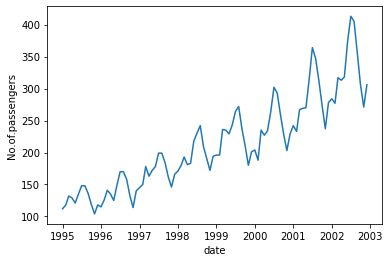

In [15]:
plt.xlabel("date")
plt.ylabel("No.of.passengers")
plt.plot(indexedDataset)
plt.show

In [17]:
rolmean = indexedDataset.rolling(window=12).mean()

In [18]:
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


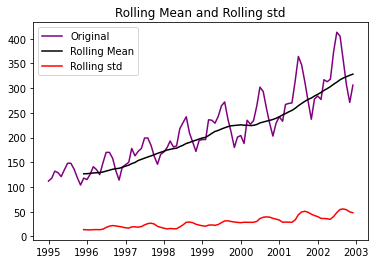

In [19]:
orig = plt.plot(indexedDataset, color='purple', label = 'Original')
mean = plt.plot(rolmean, color = 'black', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'red', label = 'Rolling std')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Rolling std')
plt.show(block=False)

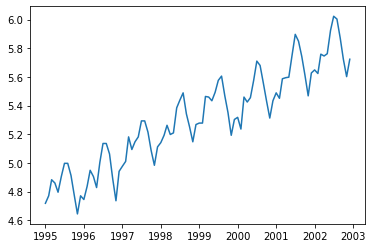

In [21]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)
plt.show()

In [22]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()

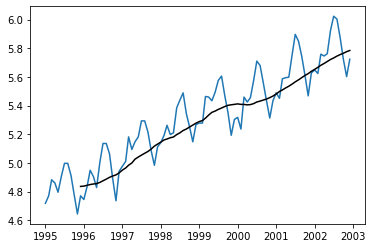

In [23]:
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage,color='black')

In [30]:
df = indexedDataset_logScale - movingAverage
df.head(4)

,Passengers
Month,
1995-01-01,NaN
1995-02-01,NaN
1995-03-01,NaN
1995-04-01,NaN


In [31]:
df.dropna(inplace = True)

In [32]:
df[:3]

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566


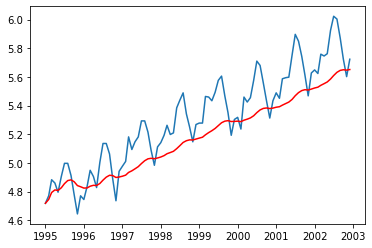

In [33]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

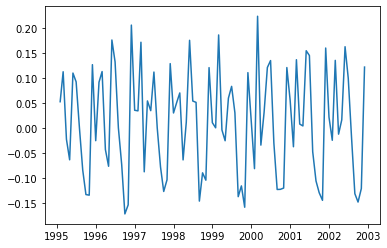

In [34]:
datasetLogScaleMinusMovingExponentDecayAverage = indexedDataset_logScale-exponentialDecayWeightedAverage
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

In [35]:
datasetLogDiffShifting[:3]

,Passengers
Month,
1995-01-01,NaN
1995-02-01,0.052186
1995-03-01,0.112117


In [36]:
datasetLogDiffShifting.dropna(inplace=True)
datasetLogDiffShifting[:3]

,Passengers
Month,
1995-02-01,0.052186
1995-03-01,0.112117
1995-04-01,-0.022990


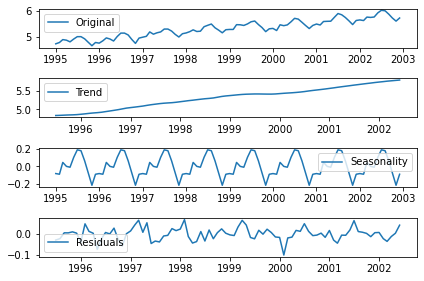

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc = 'best')
plt.tight_layout()
decompositionLogData = residual
decompositionLogData.dropna(inplace=True)

In [48]:
from statsmodels.tsa.stattools import acf,pacf

In [49]:
acf = acf(datasetLogDiffShifting, nlags = 20)
pacf = pacf(datasetLogDiffShifting, nlags = 20, method = 'ols')

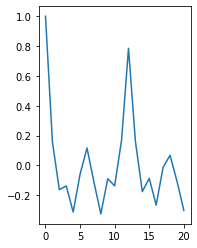

In [50]:
plt.subplot(121)
plt.plot(acf)

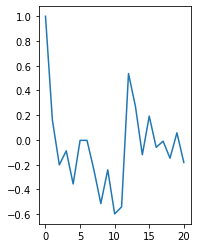

In [51]:
plt.subplot(122)
plt.plot(pacf)

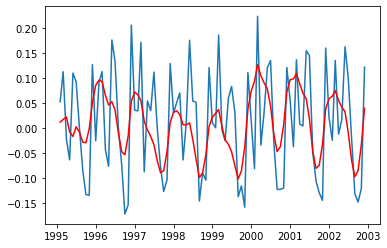

In [52]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(indexedDataset_logScale, order= (2,1,2))
results_AR = model.fit(disp = -1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color = 'red')

In [56]:
predictions_ARIMA_diff = pd.Series(results_AR. fittedvalues,copy = True)

In [57]:
predictions_ARIMA_diff

Month
1995-02-01    0.011261
1995-03-01    0.016602
1995-04-01    0.021662
1995-05-01   -0.008096
1995-06-01   -0.017394
                ...   
2002-08-01   -0.064369
2002-09-01   -0.097862
2002-10-01   -0.085675
2002-11-01   -0.033957
2002-12-01    0.038856
Length: 95, dtype: float64

In [58]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum

Month
1995-02-01    0.011261
1995-03-01    0.027863
1995-04-01    0.049526
1995-05-01    0.041430
1995-06-01    0.024035
                ...   
2002-08-01    0.954125
2002-09-01    0.856264
2002-10-01    0.770589
2002-11-01    0.736632
2002-12-01    0.775488
Length: 95, dtype: float64

In [59]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'].iloc[0], index = indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

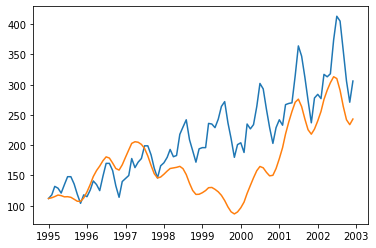

In [60]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

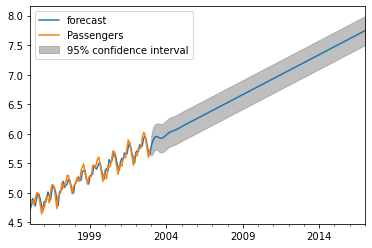

In [63]:
results_AR.plot_predict(1,264)
results = results_AR.forecast(steps = 100)

In [65]:
results[1]

array([0.08323093, 0.1043414 , 0.10880406, 0.1088073 , 0.11130402,
       0.11615835, 0.12023898, 0.12203636, 0.12228023, 0.1223429 ,
       0.12285733, 0.12358625, 0.1240984 , 0.12427416, 0.12428236,
       0.1243115 , 0.12440821, 0.12451388, 0.12457359, 0.12458745,
       0.1245875 , 0.12459665, 0.12461454, 0.12463014, 0.12463729,
       0.12463836, 0.12463853, 0.12464027, 0.12464277, 0.12464449,
       0.12464503, 0.12464504, 0.12464522, 0.12464571, 0.12464623,
       0.12464655, 0.12464665, 0.12464666, 0.12464667, 0.1246467 ,
       0.12464672, 0.12464673, 0.12464673, 0.12464674, 0.12464677,
       0.12464681, 0.12464683, 0.12464685, 0.12464686, 0.12464686,
       0.12464687, 0.12464687, 0.12464687, 0.12464687, 0.12464688,
       0.12464689, 0.1246469 , 0.12464691, 0.12464692, 0.12464692,
       0.12464693, 0.12464694, 0.12464694, 0.12464695, 0.12464695,
       0.12464696, 0.12464697, 0.12464697, 0.12464698, 0.12464699,
       0.124647  , 0.124647  , 0.12464701, 0.12464701, 0.12464

In [66]:
len(results[1])

100